In [ ]:
!nvidia-smi

Sun Apr  4 19:16:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import json
import random
import sklearn
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Load training data into images and labels lists


images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
labels list consists of ground truth masks -  numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""
path2 = '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/data/'
path = './data/' # Replace this line with path to data directory
path_images = os.path.join(path2, 'images')
path_labels = os.path.join(path2, 'labels')
with open('/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/training_data.json', 'r') as f:
    dict_training = json.load(f)

images = []
labels = []
for entry in tqdm(dict_training):
    image = nib.load(os.path.join(path_images, entry['image'][:-3]))
    label = nib.load(os.path.join(path_labels, entry['label'][:-3]))
    images.append(image.get_fdata())
    labels.append(label.get_fdata())

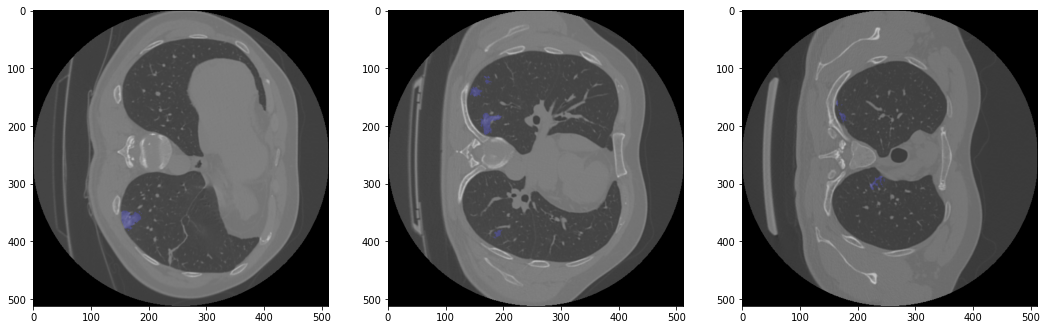

In [ ]:
#Visualize some of the slices
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask):
    # image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 7
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

# **U-Net model comprises four levels of blocks containing two convolutional layers with batch normalization and ReLU**

In [ ]:
import torch.nn as nn

class conv_block(torch.nn.Module):

    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias = False),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias = False),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = conv_block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = conv_block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder5 = conv_block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = conv_block((features * 8) * 2, features * 8)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = conv_block((features * 4) * 2, features * 4)

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = conv_block((features * 2) * 2, features * 2)

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = conv_block(features * 2, features)

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))



In [ ]:
#UNeT TEST
test_unet = UNet(1, 1)
assert tuple(test_unet(torch.randn(1, 1, 256, 256)).shape) == (1, 1, 256, 256)
print("Success!")


Success!


# **As a loss function, use DiceLoss**

In [ ]:
import torch.nn as nn


class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

#**Data processing, split into training and validation samples, using affine transformations of the training sample during model training (rotation by a small angle), output of training and validation graphs**

In [ ]:
from torch.utils.data import  DataLoader, TensorDataset
def data_loaders(x, y, x_val, y_val):
    dataset_train = TensorDataset(x, y)
    dataset_valid = TensorDataset(x_val, y_val)

    loader_train = DataLoader(
        dataset_train,
        batch_size=4,
        shuffle=True,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=2,
        drop_last=False,
    )

    return loader_train, loader_valid

In [ ]:
X_img = []
Y_img = []

for i in range(len(images)):
    for deeper in range((images[i].shape[2])):
        X_img.append(images[i][..., deeper].copy().astype(np.float32))
        Y_img.append(labels[i][..., deeper].copy().astype(np.float32))

images = []
labels = []

X_img = (X_img - np.min(X_img)) / (np.max(X_img) - np.min(X_img) + 1e-8)

valid_len = 40
X_img_valid = torch.tensor(X_img[len(X_img) - valid_len:len(X_img)]);
Y_img_valid = torch.tensor(Y_img[len(Y_img) - valid_len:len(Y_img)]);

X_img = torch.tensor(X_img[0:len(X_img) - valid_len]);
Y_img = torch.tensor(Y_img[0:len(Y_img) - valid_len]);

loader_train, loader_valid = data_loaders(X_img, Y_img, X_img_valid, Y_img_valid)

In [ ]:
loader_train, loader_valid = data_loaders(X_img, Y_img, X_img_valid, Y_img_valid)

In [ ]:
from torchvision import transforms

def make_transform(new_train_images, new_train_labels):
        angle = random.random() * 40 - 20    
        new_train_images = transforms.functional.affine(new_train_images, angle = angle, translate=(0,0), scale=1, shear=0)
        new_train_labels = transforms.functional.affine(new_train_labels, angle = angle, translate=(0,0), scale=1, shear=0)
        return new_train_images, new_train_labels

In [ ]:
def make_valid_loss(model, loader_valid):
    loss = 0.0
    n = 0
    for valid_train, valid_test in tqdm(loader_valid):
        torch.cuda.empty_cache()
        valid_train = valid_train.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
        valid_test  = valid_test.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
        pred = model(valid_train)
        model_loss = criterion(pred, valid_test)
        loss += float(model_loss)
        n += 1
    return  loss / n
def plot_loss(arg1, arg2=None):
    fig = plt.figure()
    plt.plot(arg1, color = 'Red', label = 'Train')
    if (arg2):
      plt.plot(arg2, color = 'Blue', label = 'Valid')
    plt.legend(loc = 'upper right')
    plt.show()

In [ ]:
device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
criterion = DiceLoss()
unet = UNet(1, 1).to(device)
lr = 0.0001
weight_decay = 0.00001
optimizer = torch.optim.Adam(unet.parameters(), lr= lr, weight_decay = weight_decay)

In [ ]:
valid_loss = []
dice_train = []
path_to_save = [
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_5.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_10.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_15.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_20.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_25.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_30.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_35.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_40.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_45.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_50.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_55.pt',
                '/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_60.pt']

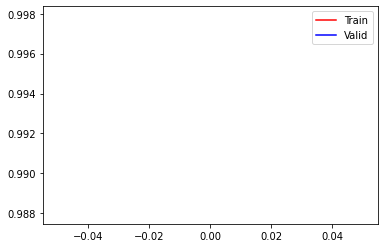

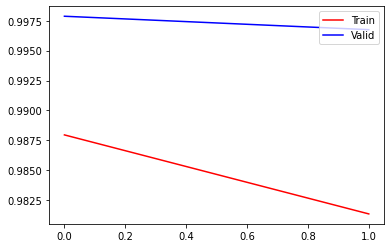

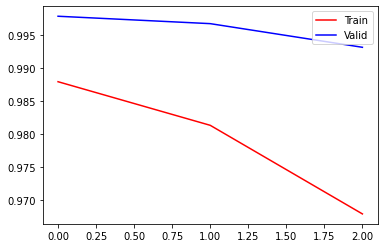

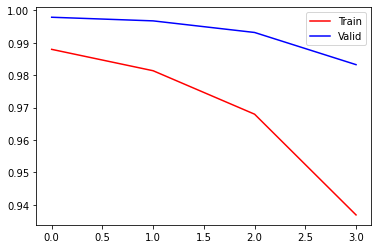

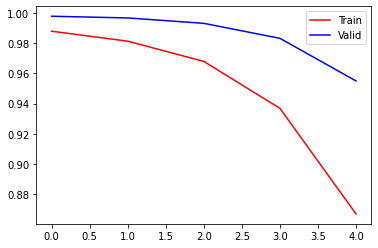

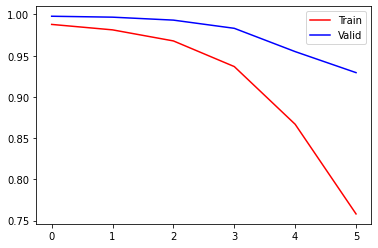

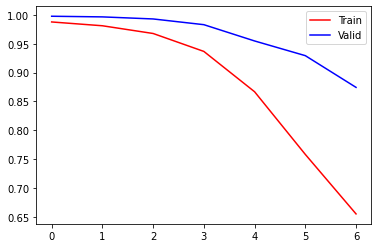

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(30):
    sum_loss = 0
    n = 0
    unet.train()
    for x_train, y_test in tqdm(loader_train):
        torch.cuda.empty_cache()
        if (n % 2 ==0):
              x_train, y_test = make_transform(x_train, y_test)
        x_train = x_train.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
        y_test = y_test.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
        optimizer.zero_grad()
        pred = unet(x_train)
        unet_loss = criterion(pred, y_test)
        unet_loss.backward()
        optimizer.step()
        n += 1
        sum_loss += float(criterion(pred, y_test))
    
    dice_train.append(sum_loss / n)

    if ((epoch + 5) % 5 == 0):
        torch.save(unet.state_dict(), path_to_save[epoch // 5])
    valid_loss.append(make_valid_loss(unet, loader_valid))
    plot_loss(dice_train, valid_loss)

**Try to see how my model segmented the covid**


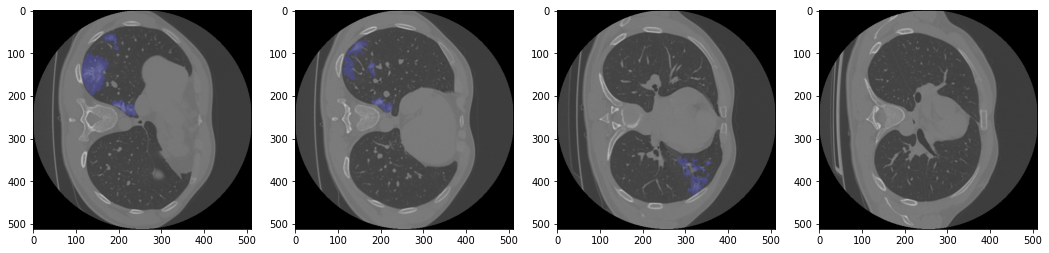

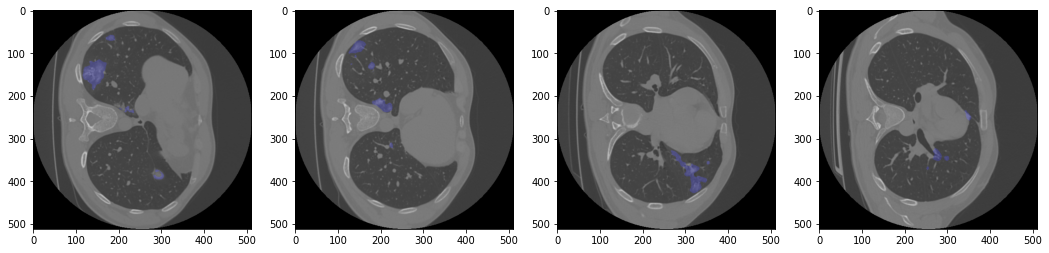

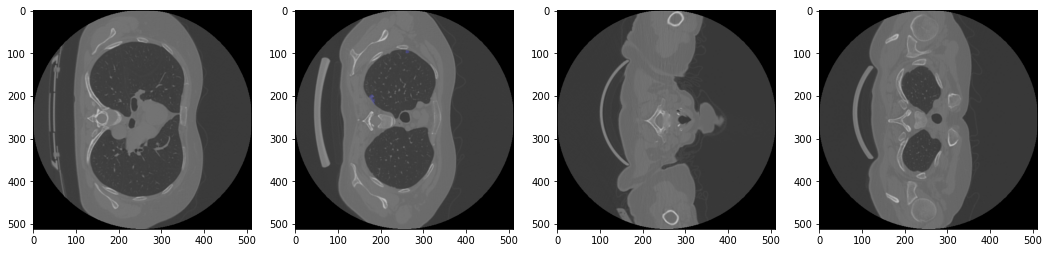

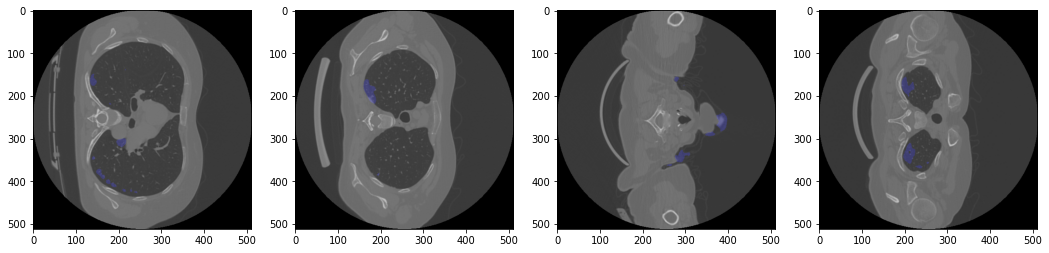

In [ ]:
def blend(image, mask):
    # image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )
def Plot_train(arg1, arg2):
    torch.cuda.empty_cache()
    patient_num = 39
    slices_num = (14, 17, 22, 26) 

    slices = []
    my_slices = []
    for idx in slices_num:
        slices.append(blend(
            arg1[idx + patient_num * 37],
            arg2[idx + patient_num * 37]
        ))
        x = []
        x_tmp = arg1[idx + patient_num * 37].detach().numpy()
        x.append(x_tmp)
        
        x = torch.tensor(x)
        x = x.unsqueeze_(1).to(device = 'cuda', dtype=torch.float)
        y = unet(x).to(device = 'cpu')
        my_slices.append(blend(
            arg1[idx + patient_num * 37],
            (y[0][0]) >= 0.5
        ))

    figure1 = plt.figure(figsize=(18, 18))
    for i, image in enumerate(slices):
        ax = figure1.add_subplot(1, len(slices), i + 1)
        ax.imshow(slices[i])
    figure2 = plt.figure(figsize=(18, 18)) 
    for i, image in enumerate(my_slices):
        ax = figure2.add_subplot(1, len(my_slices), i + 1)
        ax.imshow(my_slices[i])

def Plot_valid(arg1, arg2):
    torch.cuda.empty_cache()
    slices_num = (3, 10, 19, 14) 
    slices = []
    my_slices = []
    for idx in slices_num:
        slices.append(blend(
            arg1[idx],
            arg2[idx]
        ))
        x = []
        x_tmp = arg1[idx].detach().numpy()
        x.append(x_tmp)
        x = torch.tensor(x)
        x = x.unsqueeze_(1).to(device = 'cuda', dtype=torch.float)
        y = unet(x).to(device = 'cpu')
        my_slices.append(blend(
            arg1[idx],
            (y[0][0] >= 0.5)
        ))

    figure1 = plt.figure(figsize=(18, 18))
    for i, image in enumerate(slices):
        ax = figure1.add_subplot(1, len(slices), i + 1)
        ax.imshow(slices[i])
    figure2 = plt.figure(figsize=(18, 18)) 
    for i, image in enumerate(my_slices):
        ax = figure2.add_subplot(1, len(my_slices), i + 1)
        ax.imshow(my_slices[i])

Plot_train(X_img, Y_img)

Plot_valid(X_img_valid, Y_img_valid)

# **Load a test sample, predict the result and visualize it, if it fits, save it ".csv " file**

In [ ]:

with open('/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/testing_data.json', 'r') as f:
    dict_testing = json.load(f)
    

images_testig = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image'][:-3]))
    images_testig.append(image.get_fdata())

In [ ]:
test = []
for i in range(len(images_testig)):
    for deeper in range((images_testig[i].shape[2])):
        test.append(images_testig[i][..., deeper].astype(np.int16))

test = (test - np.min(test)) / (np.max(test) - np.min(test))
test = torch.tensor(test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataloader = DataLoader(
    dataset = test,
    batch_size = 2,
    shuffle = False)
test_model = UNet(1, 1).to('cuda')
test_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/medical-imaging-2021/Unet/Second_5.pt'))
# test_model = unet

<All keys matched successfully>

In [ ]:
ans = []
for item in tqdm(dataloader):
    item = item.unsqueeze(1).to(device = 'cuda', dtype=torch.float)
    pred = test_model(item)
    for i in range(len(pred)):
        y = pred[i][0].to('cpu') >= 0.5
        ans.append(y.detach().numpy())
    torch.cuda.empty_cache()

In [ ]:
labels_predicted = []
idx = 0
for i in range(len(images_testig)):
    tans = []
    for deeper in range((images_testig[i].shape[2])):
        tans.append(ans[idx + deeper])
    tans = np.asarray(tans)
    tans = np.swapaxes(tans, 0, 1)
    tans = np.swapaxes(tans, 1, 2)
    idx += images_testig[i].shape[2]
    labels_predicted.append(tans)


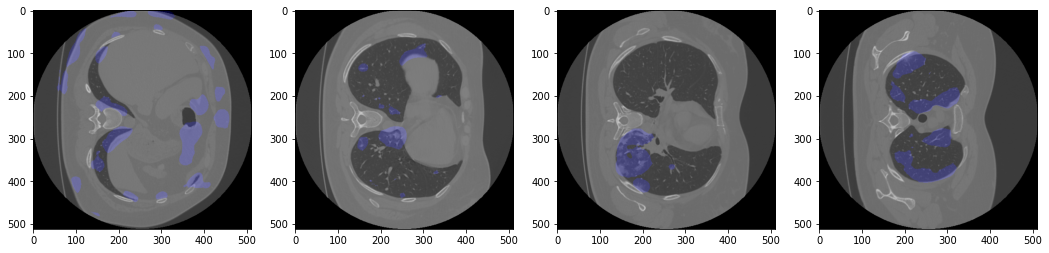

In [ ]:
# Visualize some of the predictions

patient_num = 2
slices_num = (7, 14, 21, 29)
slices = []

for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        labels_predicted[patient_num][..., idx]
    ))


figure1 = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure1.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])


In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]
with open("/content/drive/MyDrive/segnet/Submit.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(labels_predicted)):
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])